Hard switch: t>t_swap

In [1]:
import numpy as np
from scipy.integrate import solve_ivp

def simulate_glv_regime_time_switch(
    x0: np.ndarray,
    timepoints: np.ndarray,
    r1: np.ndarray, A1: np.ndarray,
    r2: np.ndarray, A2: np.ndarray,
    t_swap: float,
    atol: float = 1e-8, rtol: float = 1e-6,
):
    """
    Hard switch at a known time t_swap.
    Returns:
      X_true: (T, n)
      s_true: (T,)  integer regime label in {1,2}
    """
    x0 = np.asarray(x0, float)
    timepoints = np.asarray(timepoints, float)
    t0, tf = float(timepoints[0]), float(timepoints[-1])
    n = x0.size

    # split timepoints into two segments
    tp1 = timepoints[timepoints <= t_swap]
    tp2 = timepoints[timepoints >= t_swap]

    def rhs_factory(r, A):
        def rhs(t, x):
            x = np.nan_to_num(x, nan=0.0)
            x = np.maximum(x, 0.0)
            return x * (r + A.dot(x))
        return rhs

    # segment 1
    if tp1.size == 0:
        # no points before swap: start directly in regime 2
        x_at_swap = x0
        X1 = np.zeros((0, n))
    else:
        sol1 = solve_ivp(
            fun=rhs_factory(r1, A1),
            t_span=(t0, float(tp1[-1])),
            y0=x0,
            t_eval=tp1,
            method="RK45",
            atol=atol, rtol=rtol,
        )
        if not sol1.success:
            raise RuntimeError(sol1.message)
        X1 = sol1.y.T
        x_at_swap = X1[-1].copy()

    # segment 2 (only if needed)
    if tp2.size == 0:
        X2 = np.zeros((0, n))
    else:
        # If tp2 starts earlier than tp1 ended, we need the state at tp2[0] = t_swap.
        # simplest: integrate from max(t_swap, tp2[0]) with y0 = x_at_swap
        t_start2 = float(tp2[0])
        # if tp1 ended before t_start2 (e.g. gap), integrate without saving
        if tp1.size > 0 and float(tp1[-1]) < t_start2:
            sol_gap = solve_ivp(
                fun=rhs_factory(r1, A1),
                t_span=(float(tp1[-1]), t_start2),
                y0=x_at_swap,
                t_eval=[t_start2],
                method="RK45",
                atol=atol, rtol=rtol,
            )
            if not sol_gap.success:
                raise RuntimeError(sol_gap.message)
            x_at_swap = sol_gap.y[:, -1].copy()

        sol2 = solve_ivp(
            fun=rhs_factory(r2, A2),
            t_span=(t_start2, tf),
            y0=x_at_swap,
            t_eval=tp2,
            method="RK45",
            atol=atol, rtol=rtol,
        )
        if not sol2.success:
            raise RuntimeError(sol2.message)
        X2 = sol2.y.T

    # merge (avoid double-counting the exact t_swap if it appears in both tp1 and tp2)
    if tp1.size > 0 and tp2.size > 0 and np.isclose(tp1[-1], tp2[0]):
        X = np.vstack([X1[:-1], X2])
        t_all = np.concatenate([tp1[:-1], tp2])
    else:
        X = np.vstack([X1, X2])
        t_all = np.concatenate([tp1, tp2])

    # map back to original timepoints order
    # (t_all should match timepoints exactly if you split with <= / >=)
    X_true = np.empty((timepoints.size, n))
    idx_map = {float(t): i for i, t in enumerate(t_all)}
    for i, t in enumerate(timepoints):
        X_true[i] = X[idx_map[float(t)]]

    s_true = np.where(timepoints < t_swap, 1, 2).astype(int)
    return X_true, s_true

Hard-switch demo
  n_species = 4
  t_swap    = 8.0
  regime counts: #1=160, #2=241
  relative derivative jump at swap ≈ 1.274e+01


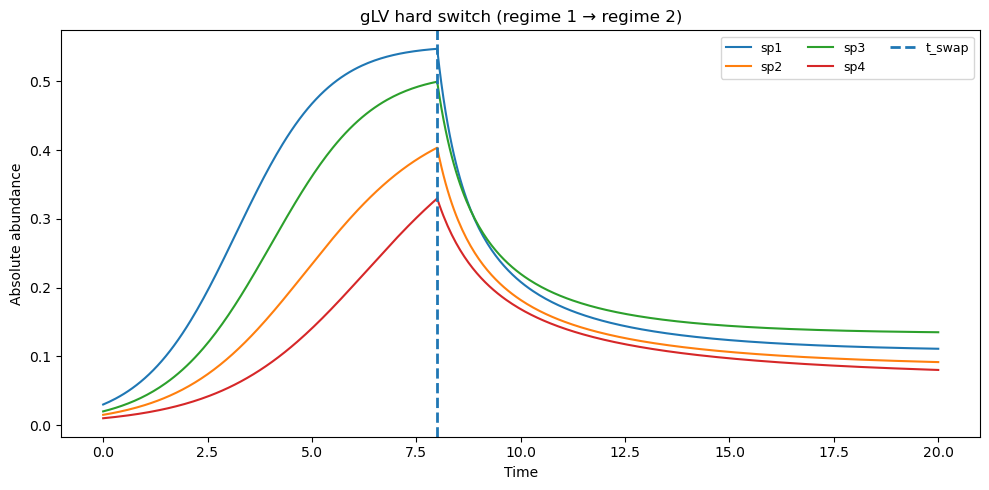

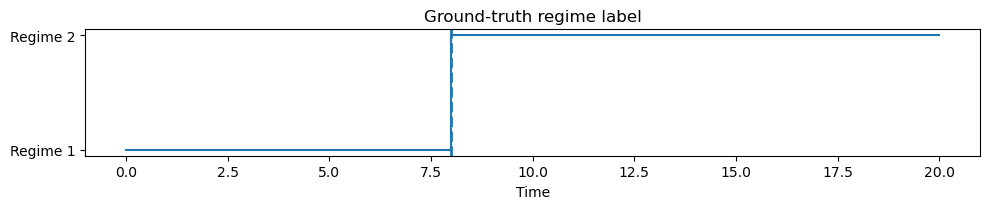

In [3]:
import matplotlib.pyplot as plt
# -----------------------------
# Choose parameters (stable + obvious switch)
# -----------------------------
n = 4
x0 = np.array([0.03, 0.015, 0.02, 0.01], dtype=float)

# time grid and swap time
timepoints = np.linspace(0.0, 20.0, 401)  # dense for smooth curves
t_swap = 8.0

# Regime 1: moderate growth + mild competition
r1 = np.array([0.9, 0.7, 0.8, 0.6], dtype=float)
A1 = np.array([
    [-1.6, -0.10,  0.05,  0.00],
    [-0.05, -1.4, -0.08,  0.03],
    [ 0.04, -0.06, -1.5, -0.07],
    [ 0.02,  0.01, -0.05, -1.3],
], dtype=float)

# Regime 2: growth drops + stronger competition (should bend trajectories after swap)
r2 = np.array([0.25, 0.20, 0.30, 0.15], dtype=float)
A2 = np.array([
    [-2.2, -0.18,  0.02, -0.02],
    [-0.12, -2.0, -0.15,  0.00],
    [ 0.01, -0.10, -2.1, -0.16],
    [-0.05,  0.00, -0.12, -1.9],
], dtype=float)

# -----------------------------
# Run hard-switch simulation
# -----------------------------
X_true, s_true = simulate_glv_regime_time_switch(
    x0=x0,
    timepoints=timepoints,
    r1=r1, A1=A1,
    r2=r2, A2=A2,
    t_swap=t_swap
)

# -----------------------------
# Quick verification: derivative jump at swap
# -----------------------------
def glv_rhs(x, r, A):
    x = np.maximum(np.nan_to_num(x, nan=0.0), 0.0)
    return x * (r + A.dot(x))

i_pre = np.max(np.where(timepoints < t_swap)[0])
x_pre = X_true[i_pre]

f1 = glv_rhs(x_pre, r1, A1)
f2 = glv_rhs(x_pre, r2, A2)
rel_jump = np.linalg.norm(f2 - f1) / (np.linalg.norm(f1) + 1e-12)

print("Hard-switch demo")
print(f"  n_species = {n}")
print(f"  t_swap    = {t_swap}")
print(f"  regime counts: #1={np.sum(s_true==1)}, #2={np.sum(s_true==2)}")
print(f"  relative derivative jump at swap ≈ {rel_jump:.3e}")

# -----------------------------
# Plot trajectories + swap marker
# -----------------------------
plt.figure(figsize=(10, 5))
for j in range(n):
    plt.plot(timepoints, X_true[:, j], label=f"sp{j+1}")
plt.axvline(t_swap, linestyle="--", linewidth=2, label="t_swap")
plt.xlabel("Time")
plt.ylabel("Absolute abundance")
plt.title("gLV hard switch (regime 1 → regime 2)")
plt.legend(ncol=3, fontsize=9)
plt.tight_layout()
plt.show()

# Optional: show regime labels as 0/1 step (visual sanity check)
plt.figure(figsize=(10, 2.2))
plt.step(timepoints, (s_true == 2).astype(int), where="post")
plt.axvline(t_swap, linestyle="--", linewidth=2)
plt.yticks([0, 1], ["Regime 1", "Regime 2"])
plt.xlabel("Time")
plt.title("Ground-truth regime label")
plt.tight_layout()
plt.show()

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.integrate import solve_ivp

# -----------------------------
# 0) Load original data
# -----------------------------
in_path = Path("test5sp_v1.csv")
df_raw = pd.read_csv(in_path)

comm_col = "Comm_name" if "Comm_name" in df_raw.columns else df_raw.columns[0]
time_col = "Time" if "Time" in df_raw.columns else df_raw.columns[1]
species_cols = [c for c in df_raw.columns if c.lower().startswith("sp")]
if not species_cols:
    species_cols = [c for c in df_raw.columns if c not in {comm_col, time_col}]

# clean
df_raw[time_col] = pd.to_numeric(df_raw[time_col], errors="coerce")
for c in species_cols:
    df_raw[c] = pd.to_numeric(df_raw[c], errors="coerce")
df_raw = df_raw.dropna(subset=[comm_col, time_col] + species_cols).copy()
df_raw = df_raw.sort_values([comm_col, time_col]).reset_index(drop=True)

n = len(species_cols)
assert n == 5, f"Expected 5 species (sp1..sp5). Found {n}: {species_cols}"

timepoints = np.sort(df_raw[time_col].unique().astype(float))
t0, tf = float(timepoints[0]), float(timepoints[-1])

# pick a swap time: choose the midpoint rounded to the closest existing timepoint
t_swap_raw = (t0 + tf) / 2.0
t_swap = float(timepoints[np.argmin(np.abs(timepoints - t_swap_raw))])

print("Loaded:", in_path)
print("Columns:", [comm_col, time_col] + species_cols)
print("n_communities:", df_raw[comm_col].nunique(), "n_timepoints:", timepoints.size)
print("Time range:", (t0, tf), "Chosen t_swap:", t_swap)

# -----------------------------
# 1) Hard-switch gLV simulator
# -----------------------------
def simulate_glv_regime_time_switch(
    x0: np.ndarray,
    timepoints: np.ndarray,
    r1: np.ndarray, A1: np.ndarray,
    r2: np.ndarray, A2: np.ndarray,
    t_swap: float,
    atol: float = 1e-8, rtol: float = 1e-6,
):
    x0 = np.asarray(x0, float)
    timepoints = np.asarray(timepoints, float)
    t0, tf = float(timepoints[0]), float(timepoints[-1])
    n = x0.size

    tp1 = timepoints[timepoints <= t_swap]
    tp2 = timepoints[timepoints >= t_swap]

    def rhs_factory(r, A):
        def rhs(t, x):
            x = np.maximum(np.nan_to_num(x, nan=0.0), 0.0)
            return x * (r + A.dot(x))
        return rhs

    # ---- segment 1 ----
    if tp1.size == 0:
        x_at_swap = x0
        X1 = np.zeros((0, n))
    else:
        sol1 = solve_ivp(
            fun=rhs_factory(r1, A1),
            t_span=(t0, float(tp1[-1])),
            y0=x0,
            t_eval=tp1,
            method="RK45",
            atol=atol,
            rtol=rtol,
        )
        if not sol1.success:
            raise RuntimeError(sol1.message)
        X1 = sol1.y.T
        x_at_swap = X1[-1].copy()

    # ---- segment 2 ----
    if tp2.size == 0:
        X2 = np.zeros((0, n))
    else:
        t_start2 = float(tp2[0])

        # if there's a gap, integrate regime1 to reach t_start2
        if tp1.size > 0 and float(tp1[-1]) < t_start2:
            sol_gap = solve_ivp(
                fun=rhs_factory(r1, A1),
                t_span=(float(tp1[-1]), t_start2),
                y0=x_at_swap,
                t_eval=[t_start2],
                method="RK45",
                atol=atol,
                rtol=rtol,
            )
            if not sol_gap.success:
                raise RuntimeError(sol_gap.message)
            x_at_swap = sol_gap.y[:, -1].copy()

        sol2 = solve_ivp(
            fun=rhs_factory(r2, A2),
            t_span=(t_start2, tf),
            y0=x_at_swap,
            t_eval=tp2,
            method="RK45",
            atol=atol,
            rtol=rtol,
        )
        if not sol2.success:
            raise RuntimeError(sol2.message)
        X2 = sol2.y.T

    # merge (avoid double-count t_swap)
    if tp1.size > 0 and tp2.size > 0 and np.isclose(tp1[-1], tp2[0]):
        X = np.vstack([X1[:-1], X2])
        t_all = np.concatenate([tp1[:-1], tp2])
    else:
        X = np.vstack([X1, X2])
        t_all = np.concatenate([tp1, tp2])

    # map to original timepoints (assumes timepoints are unique floats)
    idx_map = {float(t): i for i, t in enumerate(t_all)}
    X_true = np.empty((timepoints.size, n))
    for i, t in enumerate(timepoints):
        X_true[i] = X[idx_map[float(t)]]

    s_true = np.where(timepoints < t_swap, 1, 2).astype(int)
    return X_true, s_true

# -----------------------------
# 2) Two parameter sets
# -----------------------------
# (A) Switch to SLOWER after t_swap
r1_slow = np.array([0.90, 0.75, 0.85, 0.70, 0.80], dtype=float)
A1_slow = np.array([
    [-1.40, -0.06,  0.02,  0.00, -0.02],
    [-0.03, -1.30, -0.05,  0.01,  0.00],
    [ 0.01, -0.04, -1.35, -0.05, -0.02],
    [ 0.00,  0.01, -0.03, -1.20, -0.04],
    [-0.01,  0.00, -0.02, -0.03, -1.30],
], dtype=float)

r2_slow = np.array([0.25, 0.22, 0.28, 0.20, 0.24], dtype=float)
A2_slow = np.array([
    [-2.40, -0.12,  0.01, -0.02, -0.06],
    [-0.08, -2.20, -0.10,  0.00, -0.05],
    [ 0.00, -0.08, -2.30, -0.12, -0.07],
    [-0.04,  0.00, -0.09, -2.10, -0.08],
    [-0.06, -0.04, -0.06, -0.06, -2.25],
], dtype=float)

# (B) Switch to FASTER after t_swap
r1_fast = np.array([0.28, 0.25, 0.30, 0.22, 0.26], dtype=float)
A1_fast = np.array([
    [-2.30, -0.10,  0.00, -0.02, -0.05],
    [-0.07, -2.10, -0.08,  0.00, -0.04],
    [ 0.00, -0.07, -2.20, -0.09, -0.06],
    [-0.04,  0.00, -0.07, -2.00, -0.07],
    [-0.05, -0.03, -0.05, -0.05, -2.15],
], dtype=float)

r2_fast = np.array([1.05, 0.95, 1.00, 0.90, 0.98], dtype=float)
A2_fast = np.array([
    [-1.15, -0.04,  0.05,  0.02,  0.00],
    [-0.02, -1.10, -0.03,  0.04,  0.01],
    [ 0.03, -0.02, -1.12, -0.03,  0.04],
    [ 0.01,  0.03, -0.02, -1.05, -0.02],
    [ 0.00,  0.01,  0.03, -0.02, -1.10],
], dtype=float)

# -----------------------------
# 3) Simulate for each community
# -----------------------------
def simulate_all_communities(df_init, r1, A1, r2, A2, label):
    out = []
    for comm, sub in df_init.groupby(comm_col, sort=False):
        sub = sub.sort_values(time_col)
        x0 = sub.iloc[0][species_cols].to_numpy(dtype=float)
        X, s = simulate_glv_regime_time_switch(x0, timepoints, r1, A1, r2, A2, t_swap)
        for t, x, reg in zip(timepoints, X, s):
            out.append([comm, float(t), int(reg), *x.tolist(), label])
    cols = [comm_col, time_col, "regime_true"] + species_cols + ["scenario"]
    df_out = pd.DataFrame(out, columns=cols).sort_values([comm_col, time_col]).reset_index(drop=True)
    return df_out

df_sim_slow = simulate_all_communities(df_raw, r1_slow, A1_slow, r2_slow, A2_slow, label="switch_to_slower")
df_sim_fast = simulate_all_communities(df_raw, r1_fast, A1_fast, r2_fast, A2_fast, label="switch_to_faster")

# Save
out_slow = Path("test5sp_switch_to_slower.csv")
out_fast = Path("test5sp_switch_to_faster.csv")
df_sim_slow.to_csv(out_slow, index=False)
df_sim_fast.to_csv(out_fast, index=False)

print("Saved:")
print("  slower:", out_slow)
print("  faster:", out_fast)


Loaded: test5sp_v1.csv
Columns: ['Comm_name', 'Time', 'sp1', 'sp2', 'sp3', 'sp4', 'sp5']
n_communities: 11 n_timepoints: 21
Time range: (0.0, 20.0) Chosen t_swap: 10.0
Saved:
  slower: test5sp_switch_to_slower.csv
  faster: test5sp_switch_to_faster.csv


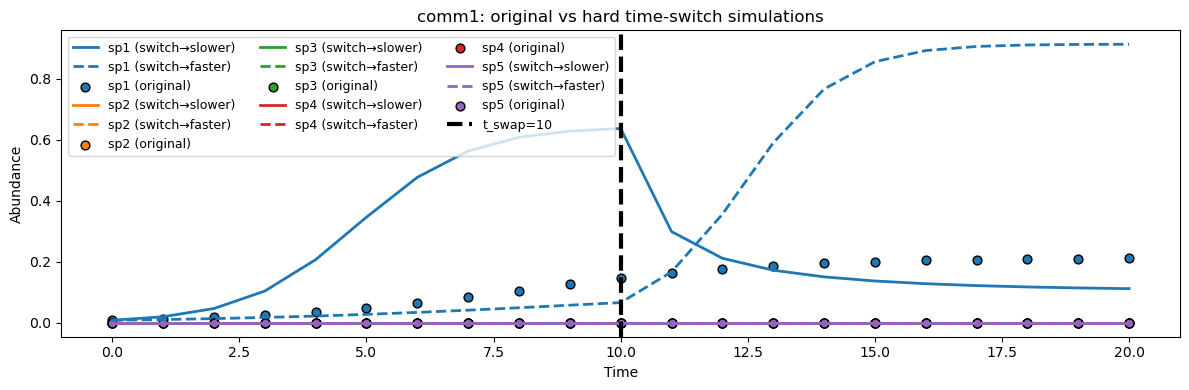

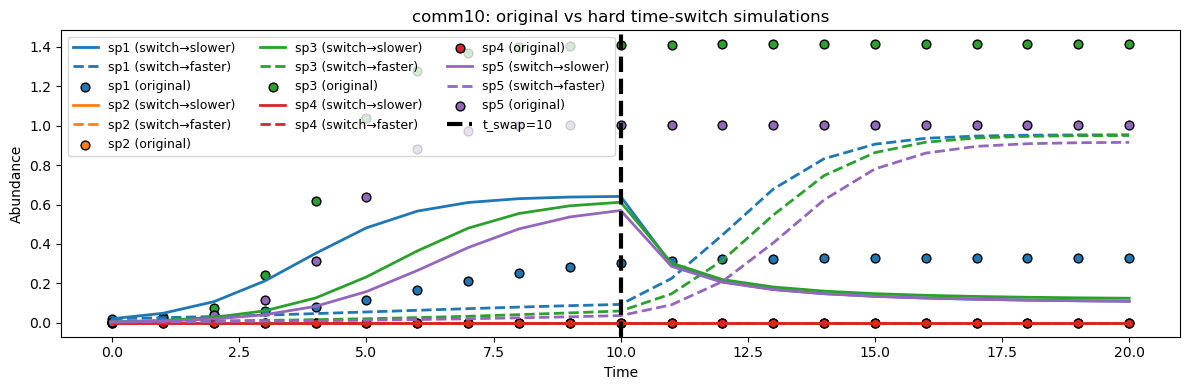

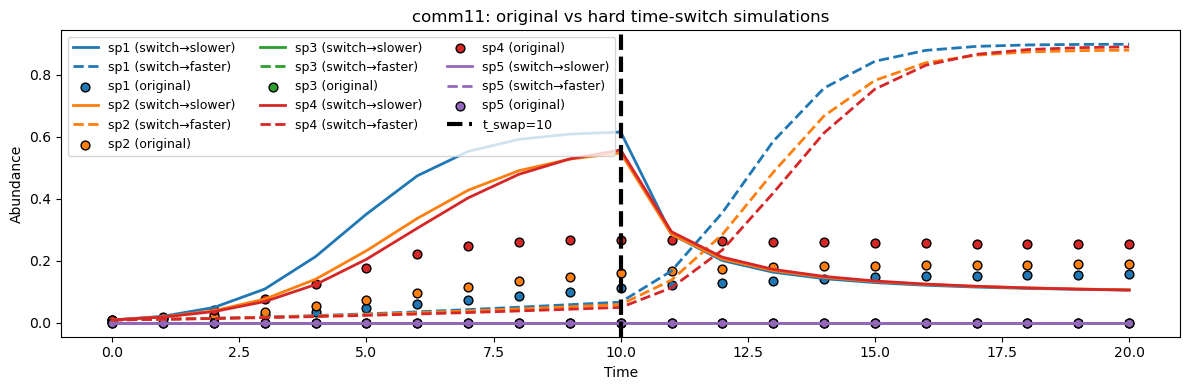

In [6]:
# -----------------------------
# 4) Plot comparison overlays (IMPROVED LEGEND)
# -----------------------------
show_n = 3
show_comms = list(df_raw[comm_col].unique()[:show_n])

for comm in show_comms:

    d0 = df_raw[df_raw[comm_col] == comm].sort_values(time_col)
    dS = df_sim_slow[df_sim_slow[comm_col] == comm].sort_values(time_col)
    dF = df_sim_fast[df_sim_fast[comm_col] == comm].sort_values(time_col)

    t = d0[time_col].to_numpy(dtype=float)

    plt.figure(figsize=(12, 4))

    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    for i, c in enumerate(species_cols):
        color = colors[i % len(colors)]

        # ---- simulated slower (solid)
        plt.plot(
            dS[time_col], dS[c],
            linestyle="-",
            linewidth=2,
            color=color,
            label=f"{c} (switch→slower)"
        )

        # ---- simulated faster (dashed)
        plt.plot(
            dF[time_col], dF[c],
            linestyle="--",
            linewidth=2,
            color=color,
            label=f"{c} (switch→faster)"
        )

        # ---- original data (points)
        plt.scatter(
            t,
            d0[c].to_numpy(dtype=float),
            s=40,
            color=color,
            marker="o",
            edgecolor="black",
            label=f"{c} (original)"
        )

    plt.axvline(t_swap, linestyle="--", linewidth=3, color="black", label=f"t_swap={t_swap:g}")

    plt.title(f"{comm}: original vs hard time-switch simulations")
    plt.xlabel("Time")
    plt.ylabel("Abundance")

    plt.legend(ncol=3, fontsize=9)
    plt.tight_layout()
    plt.show()

Loaded: test5sp_v1.csv
Communities: 11 Timepoints: 21
Time range: (0.0, 20.0) Species: ['sp1', 'sp2', 'sp3', 'sp4', 'sp5']


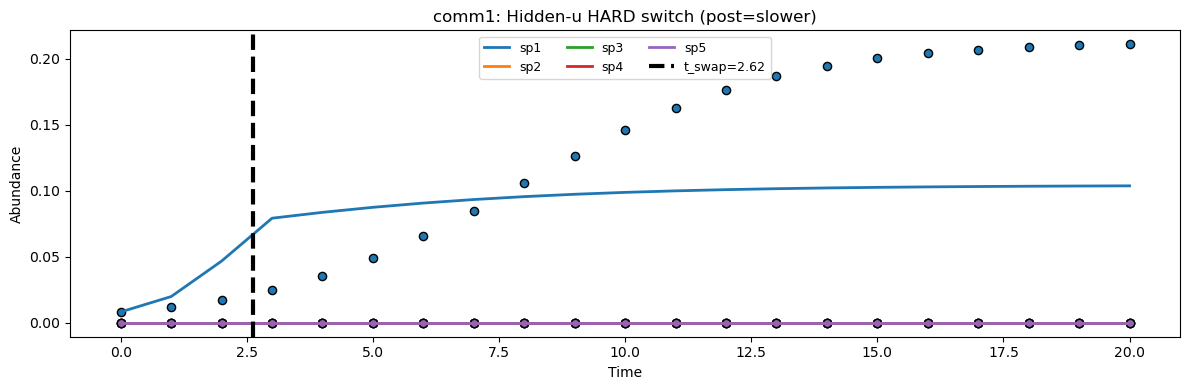

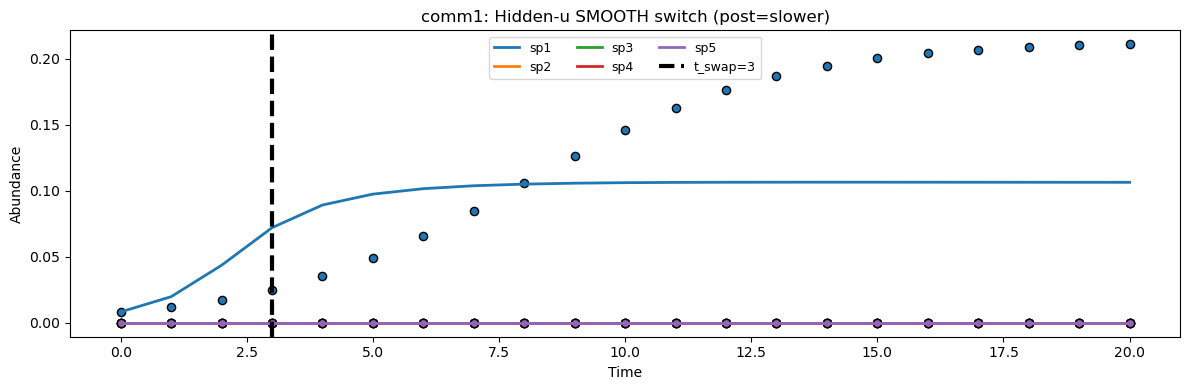

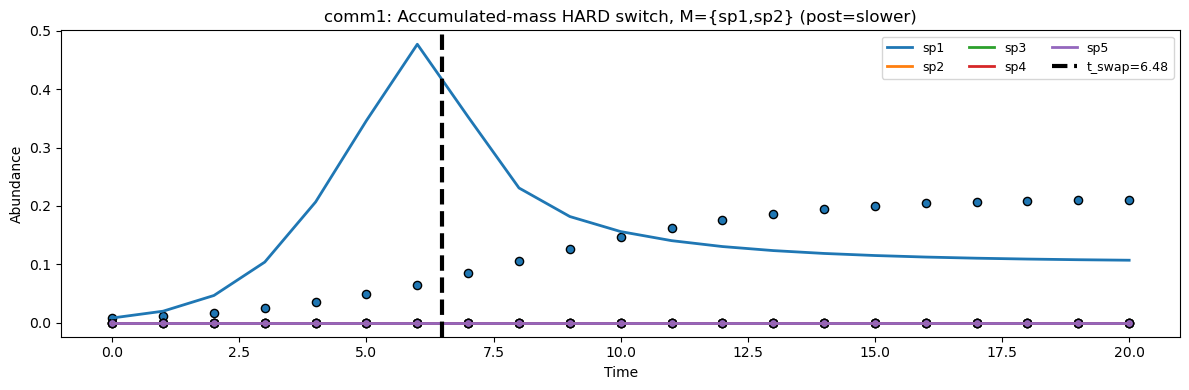

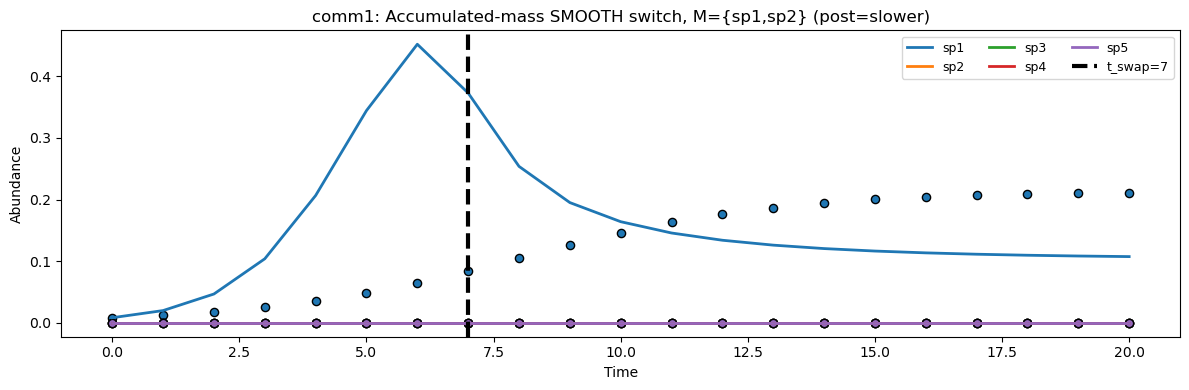

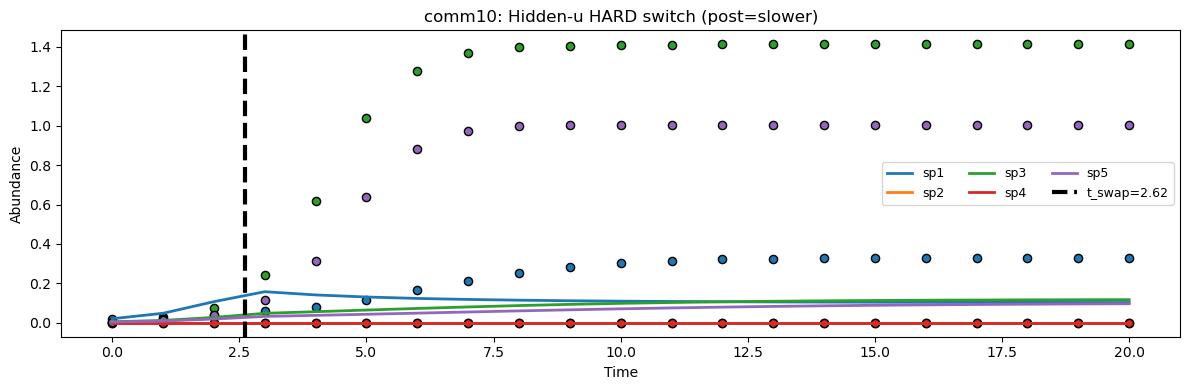

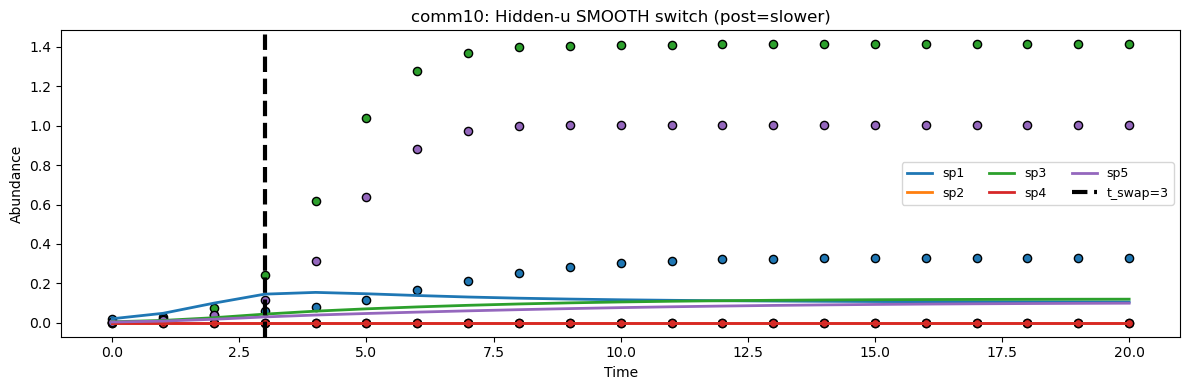

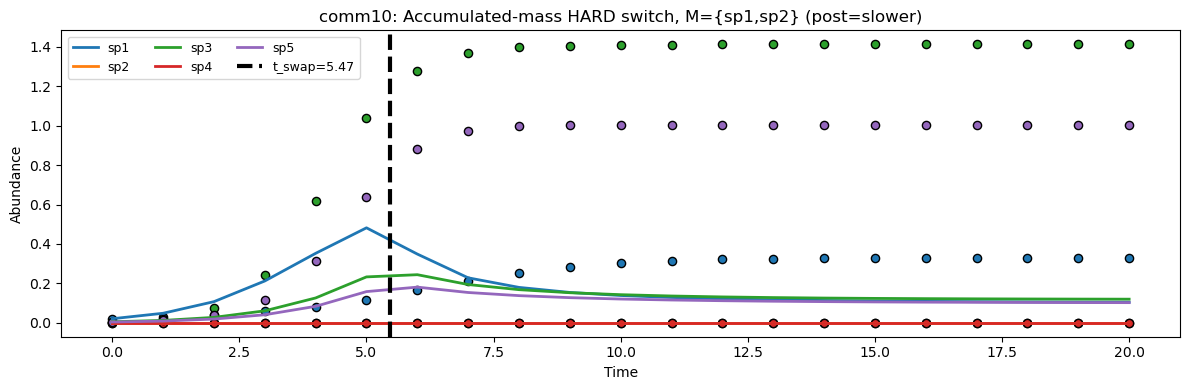

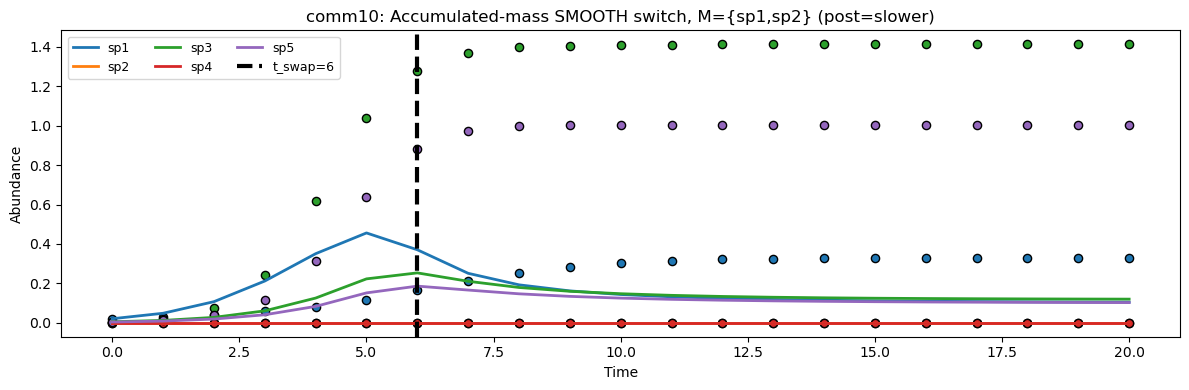

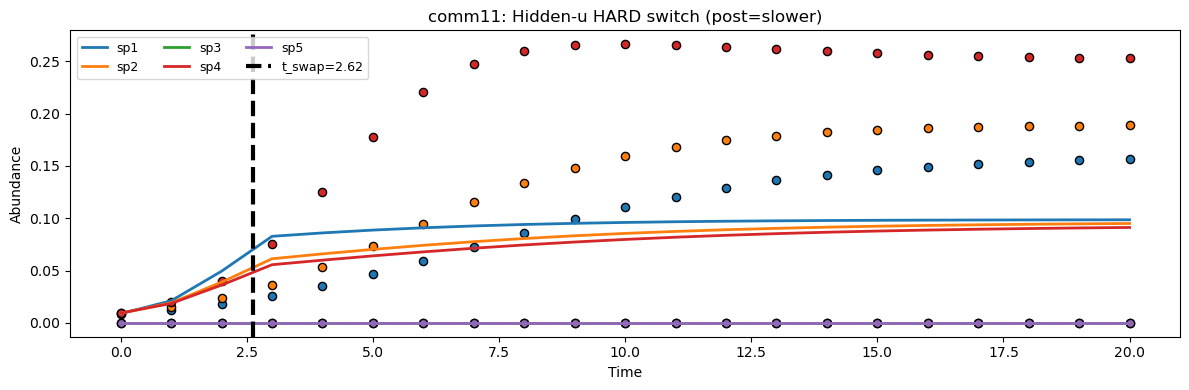

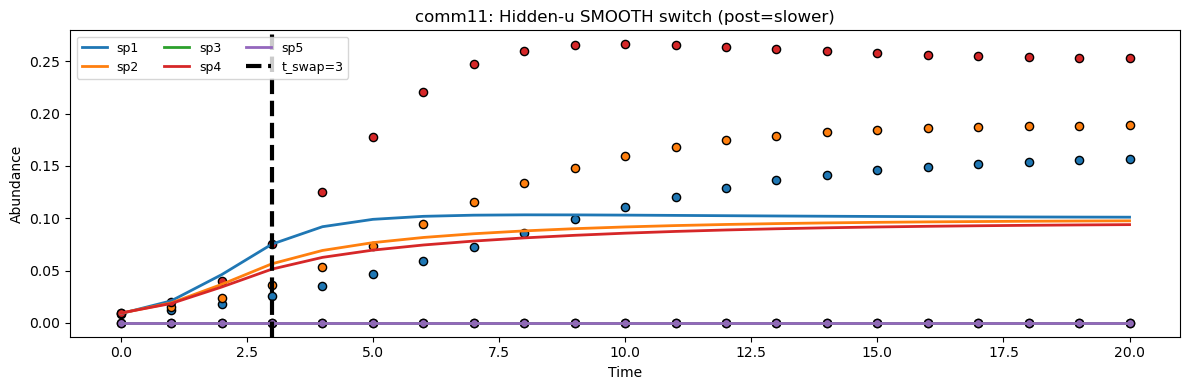

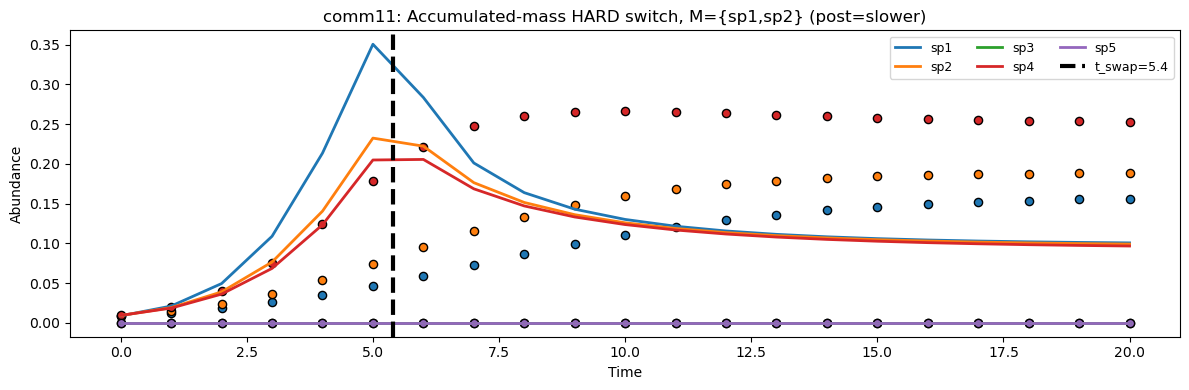

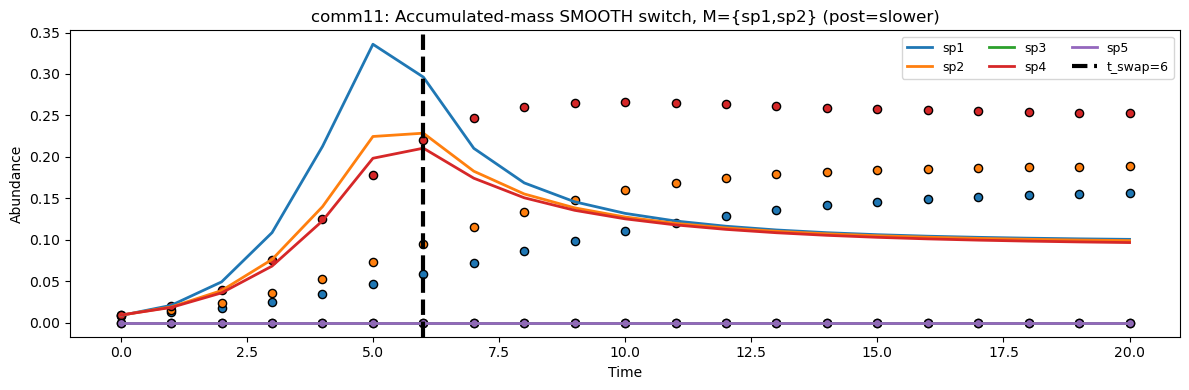

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.integrate import solve_ivp

# =========================================================
# 0) Load your original file
# =========================================================
in_path = Path("test5sp_v1.csv")
df_raw = pd.read_csv(in_path)

comm_col = "Comm_name"
time_col = "Time"
species_cols = [c for c in df_raw.columns if c.lower().startswith("sp")]
assert len(species_cols) == 5, f"Expected sp1..sp5, got: {species_cols}"

df_raw[time_col] = pd.to_numeric(df_raw[time_col], errors="coerce")
for c in species_cols:
    df_raw[c] = pd.to_numeric(df_raw[c], errors="coerce")

df_raw = df_raw.dropna(subset=[comm_col, time_col] + species_cols).copy()
df_raw = df_raw.sort_values([comm_col, time_col]).reset_index(drop=True)

timepoints = np.sort(df_raw[time_col].unique().astype(float))
t0, tf = float(timepoints[0]), float(timepoints[-1])

print("Loaded:", in_path)
print("Communities:", df_raw[comm_col].nunique(), "Timepoints:", len(timepoints))
print("Time range:", (t0, tf), "Species:", species_cols)

# =========================================================
# 1) gLV RHS
#    dx/dt = x ∘ (r + A x)
# =========================================================
def glv_rhs(x, r, A):
    x = np.maximum(np.nan_to_num(x, nan=0.0), 0.0)
    return x * (r + A.dot(x))

# =========================================================
# 2) Two regimes (pick something stable + visible effect)
# =========================================================
# Regime 1: moderate growth, mild competition
r1 = np.array([0.90, 0.75, 0.85, 0.70, 0.80], dtype=float)
A1 = np.array([
    [-1.40, -0.06,  0.02,  0.00, -0.02],
    [-0.03, -1.30, -0.05,  0.01,  0.00],
    [ 0.01, -0.04, -1.35, -0.05, -0.02],
    [ 0.00,  0.01, -0.03, -1.20, -0.04],
    [-0.01,  0.00, -0.02, -0.03, -1.30],
], dtype=float)

# Regime 2: choose either slower or faster AFTER switch
# --- slower after switch:
r2_slow = np.array([0.25, 0.22, 0.28, 0.20, 0.24], dtype=float)
A2_slow = np.array([
    [-2.40, -0.12,  0.01, -0.02, -0.06],
    [-0.08, -2.20, -0.10,  0.00, -0.05],
    [ 0.00, -0.08, -2.30, -0.12, -0.07],
    [-0.04,  0.00, -0.09, -2.10, -0.08],
    [-0.06, -0.04, -0.06, -0.06, -2.25],
], dtype=float)

# --- faster after switch:
r2_fast = np.array([1.05, 0.95, 1.00, 0.90, 0.98], dtype=float)
A2_fast = np.array([
    [-1.15, -0.04,  0.05,  0.02,  0.00],
    [-0.02, -1.10, -0.03,  0.04,  0.01],
    [ 0.03, -0.02, -1.12, -0.03,  0.04],
    [ 0.01,  0.03, -0.02, -1.05, -0.02],
    [ 0.00,  0.01,  0.03, -0.02, -1.10],
], dtype=float)

# =========================================================
# 3) Switch type A: hidden variable u(t)
#    du/dt = h(u,t)
#    t_swap = inf{ t>=0 : S(u(t)) >= theta }
#
# Here: choose a simple monotone u(t): du/dt = k_u*(1-u), u(0)=u0
# S(u)=u
# =========================================================
def simulate_hidden_u_switch_hard(x0, timepoints, r1, A1, r2, A2,
                                 u0=0.0, k_u=0.35, theta=0.6,
                                 atol=1e-8, rtol=1e-6):
    timepoints = np.asarray(timepoints, float)
    n = len(x0)

    # state = [x(0..n-1), u]
    y0 = np.concatenate([np.asarray(x0, float), np.array([u0], float)])

    def rhs_reg1(t, y):
        x = y[:n]
        u = y[n]
        dx = glv_rhs(x, r1, A1)
        du = k_u * (1.0 - u)
        return np.concatenate([dx, [du]])

    def event_u_cross(t, y):
        u = y[n]
        return u - theta
    event_u_cross.terminal = True
    event_u_cross.direction = 1

    # integrate regime 1 until event or tf
    sol1 = solve_ivp(rhs_reg1, (timepoints[0], timepoints[-1]), y0,
                     events=event_u_cross, dense_output=True,
                     atol=atol, rtol=rtol)
    if not sol1.success:
        raise RuntimeError(sol1.message)

    if sol1.t_events[0].size > 0:
        t_swap = float(sol1.t_events[0][0])
    else:
        t_swap = float(timepoints[-1])  # never switched

    y_swap = sol1.sol(t_swap)
    x_swap = y_swap[:n].copy()
    u_swap = float(y_swap[n])

    # integrate regime 2 from t_swap to tf (keep u frozen, or you can keep evolving it)
    def rhs_reg2(t, x):
        return glv_rhs(x, r2, A2)

    if t_swap < float(timepoints[-1]) - 1e-12:
        sol2 = solve_ivp(rhs_reg2, (t_swap, timepoints[-1]), x_swap,
                         dense_output=True, atol=atol, rtol=rtol)
        if not sol2.success:
            raise RuntimeError(sol2.message)
    else:
        sol2 = None

    # sample at requested timepoints
    X = np.zeros((len(timepoints), n), float)
    for i, t in enumerate(timepoints):
        if t <= t_swap or sol2 is None:
            X[i] = sol1.sol(t)[:n]
        else:
            X[i] = sol2.sol(t)

    s_true = np.where(timepoints < t_swap, 1, 2).astype(int)
    return X, s_true, t_swap, u_swap

def simulate_hidden_u_switch_smooth(x0, timepoints, r1, A1, r2, A2,
                                   u0=0.0, k_u=0.35, theta=0.6, eps=0.08,
                                   atol=1e-8, rtol=1e-6):
    timepoints = np.asarray(timepoints, float)
    n = len(x0)

    y0 = np.concatenate([np.asarray(x0, float), np.array([u0], float)])

    def sigmoid(z):
        z = np.clip(z, -60, 60)
        return 1.0 / (1.0 + np.exp(-z))

    def rhs(t, y):
        x = y[:n]
        u = y[n]
        du = k_u * (1.0 - u)
        w = sigmoid((u - theta) / eps)  # smooth switch weight
        dx = x * ((1.0 - w) * (r1 + A1.dot(x)) + w * (r2 + A2.dot(x)))
        return np.concatenate([dx, [du]])

    sol = solve_ivp(rhs, (timepoints[0], timepoints[-1]), y0,
                    t_eval=timepoints, atol=atol, rtol=rtol)
    if not sol.success:
        raise RuntimeError(sol.message)

    Y = sol.y.T
    X = np.maximum(Y[:, :n], 0.0)
    u_traj = Y[:, n]
    # define an approximate swap time where u crosses theta
    idx = np.where(u_traj >= theta)[0]
    t_swap = float(timepoints[idx[0]]) if idx.size else float(timepoints[-1])
    s_true = np.where(timepoints < t_swap, 1, 2).astype(int)
    return X, s_true, t_swap

# =========================================================
# 4) Switch type B: accumulated mass A_M(t)
#    A_M(t) = sum_{i in M} ∫ x_i(s) ds
#    trigger when c1*A_M(t) >= M_init  (same as screenshot)
#
# We augment state with z = A_M(t), dz/dt = sum_{i in M} x_i(t)
# =========================================================
def simulate_mass_switch_hard(x0, timepoints, r1, A1, r2, A2,
                             M_idx=(0,1), c1=1.0, M_init=1.2,
                             atol=1e-8, rtol=1e-6):
    timepoints = np.asarray(timepoints, float)
    n = len(x0)

    # state = [x, z]
    y0 = np.concatenate([np.asarray(x0, float), np.array([0.0], float)])

    M_idx = np.array(M_idx, dtype=int)

    def rhs_reg1(t, y):
        x = y[:n]
        z = y[n]
        dx = glv_rhs(x, r1, A1)
        dz = float(np.sum(x[M_idx]))  # d/dt of integral = sum of selected species
        return np.concatenate([dx, [dz]])

    def event_mass(t, y):
        z = y[n]
        return c1 * z - M_init
    event_mass.terminal = True
    event_mass.direction = 1

    sol1 = solve_ivp(rhs_reg1, (timepoints[0], timepoints[-1]), y0,
                     events=event_mass, dense_output=True,
                     atol=atol, rtol=rtol)
    if not sol1.success:
        raise RuntimeError(sol1.message)

    if sol1.t_events[0].size > 0:
        t_swap = float(sol1.t_events[0][0])
    else:
        t_swap = float(timepoints[-1])

    y_swap = sol1.sol(t_swap)
    x_swap = y_swap[:n].copy()
    z_swap = float(y_swap[n])

    def rhs_reg2(t, x):
        return glv_rhs(x, r2, A2)

    if t_swap < float(timepoints[-1]) - 1e-12:
        sol2 = solve_ivp(rhs_reg2, (t_swap, timepoints[-1]), x_swap,
                         dense_output=True, atol=atol, rtol=rtol)
        if not sol2.success:
            raise RuntimeError(sol2.message)
    else:
        sol2 = None

    X = np.zeros((len(timepoints), n), float)
    for i, t in enumerate(timepoints):
        if t <= t_swap or sol2 is None:
            X[i] = sol1.sol(t)[:n]
        else:
            X[i] = sol2.sol(t)

    s_true = np.where(timepoints < t_swap, 1, 2).astype(int)
    return X, s_true, t_swap, z_swap

def simulate_mass_switch_smooth(x0, timepoints, r1, A1, r2, A2,
                               M_idx=(0,1), c1=1.0, M_init=1.2, eps=0.15,
                               atol=1e-8, rtol=1e-6):
    timepoints = np.asarray(timepoints, float)
    n = len(x0)

    y0 = np.concatenate([np.asarray(x0, float), np.array([0.0], float)])
    M_idx = np.array(M_idx, dtype=int)

    def sigmoid(z):
        z = np.clip(z, -60, 60)
        return 1.0 / (1.0 + np.exp(-z))

    def rhs(t, y):
        x = y[:n]
        z = y[n]
        trigger = c1 * z - M_init
        w = sigmoid(trigger / eps)  # smooth Heaviside
        dx = x * ((1.0 - w) * (r1 + A1.dot(x)) + w * (r2 + A2.dot(x)))
        dz = float(np.sum(x[M_idx]))
        return np.concatenate([dx, [dz]])

    sol = solve_ivp(rhs, (timepoints[0], timepoints[-1]), y0,
                    t_eval=timepoints, atol=atol, rtol=rtol)
    if not sol.success:
        raise RuntimeError(sol.message)

    Y = sol.y.T
    X = np.maximum(Y[:, :n], 0.0)
    z_traj = Y[:, n]
    trigger = c1 * z_traj - M_init
    idx = np.where(trigger >= 0)[0]
    t_swap = float(timepoints[idx[0]]) if idx.size else float(timepoints[-1])
    s_true = np.where(timepoints < t_swap, 1, 2).astype(int)
    return X, s_true, t_swap

# =========================================================
# 5) Run + plot overlay for a few communities
# =========================================================
def overlay_plot(comm, d0, t, X_sim, t_swap, title_suffix):
    plt.figure(figsize=(12, 4))
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    for i, sp in enumerate(species_cols):
        col = colors[i % len(colors)]
        # original = dots
        plt.scatter(t, d0[sp].to_numpy(float), s=35, marker="o", color=col, edgecolor="black")
        # simulation = line
        plt.plot(t, X_sim[:, i], linewidth=2, color=col, label=sp)

    plt.axvline(t_swap, linestyle="--", linewidth=3, color="black", label=f"t_swap={t_swap:.3g}")
    plt.title(f"{comm}: {title_suffix}")
    plt.xlabel("Time")
    plt.ylabel("Abundance")
    plt.legend(ncol=3, fontsize=9)
    plt.tight_layout()
    plt.show()

# Choose whether post-switch becomes slower or faster:
POST = "slower"  # change to "faster"
r2, A2 = (r2_slow, A2_slow) if POST == "slower" else (r2_fast, A2_fast)

# pick a few communities to visualize
show_n = 3
communities = df_raw[comm_col].unique()[:show_n]

for comm in communities:
    sub = df_raw[df_raw[comm_col] == comm].sort_values(time_col)
    x0 = sub.iloc[0][species_cols].to_numpy(float)
    t = sub[time_col].to_numpy(float)

    # ---- A) hidden u switch (hard)
    X_u_hard, s_u_hard, t_swap_u, u_at = simulate_hidden_u_switch_hard(
        x0, timepoints, r1, A1, r2, A2,
        u0=0.0, k_u=0.35, theta=0.6
    )
    overlay_plot(comm, sub, timepoints, X_u_hard, t_swap_u,
                 f"Hidden-u HARD switch (post={POST})")

    # ---- A) hidden u switch (smooth)
    X_u_smooth, s_u_smooth, t_swap_u2 = simulate_hidden_u_switch_smooth(
        x0, timepoints, r1, A1, r2, A2,
        u0=0.0, k_u=0.35, theta=0.6, eps=0.08
    )
    overlay_plot(comm, sub, timepoints, X_u_smooth, t_swap_u2,
                 f"Hidden-u SMOOTH switch (post={POST})")

    # ---- B) accumulated mass switch (hard)
    # choose M as {sp1, sp2} -> indices (0,1)
    X_m_hard, s_m_hard, t_swap_m, z_at = simulate_mass_switch_hard(
        x0, timepoints, r1, A1, r2, A2,
        M_idx=(0,1), c1=1.0, M_init=1.2
    )
    overlay_plot(comm, sub, timepoints, X_m_hard, t_swap_m,
                 f"Accumulated-mass HARD switch, M={{sp1,sp2}} (post={POST})")

    # ---- B) accumulated mass switch (smooth)
    X_m_smooth, s_m_smooth, t_swap_m2 = simulate_mass_switch_smooth(
        x0, timepoints, r1, A1, r2, A2,
        M_idx=(0,1), c1=1.0, M_init=1.2, eps=0.15
    )
    overlay_plot(comm, sub, timepoints, X_m_smooth, t_swap_m2,
                 f"Accumulated-mass SMOOTH switch, M={{sp1,sp2}} (post={POST})")

In [10]:
# =========================================================
# SAVE ALL SIMULATED SWITCH DATA TO CSV
# =========================================================

def build_switch_dataframe(df_raw, sim_function, scenario_name, **sim_kwargs):
    rows = []

    for comm, sub in df_raw.groupby(comm_col, sort=False):
        sub = sub.sort_values(time_col)
        x0 = sub.iloc[0][species_cols].to_numpy(float)

        X_sim, s_true, t_swap = sim_function(
            x0, timepoints, r1, A1, r2, A2, **sim_kwargs
        )[:3]  # take first 3 returns

        for t, x, s in zip(timepoints, X_sim, s_true):
            rows.append([comm, float(t), int(s), *x.tolist(), scenario_name])

    cols = [comm_col, time_col, "regime_true"] + species_cols + ["scenario"]
    df_out = pd.DataFrame(rows, columns=cols)
    df_out = df_out.sort_values([comm_col, time_col]).reset_index(drop=True)
    return df_out


# ---- choose post-switch regime (slower or faster)
POST = "slower"  # change to "faster" if desired
r2, A2 = (r2_slow, A2_slow) if POST == "slower" else (r2_fast, A2_fast)

# =========================================================
# 1) Hidden-u HARD
# =========================================================
df_hidden_hard = build_switch_dataframe(
    df_raw,
    simulate_hidden_u_switch_hard,
    scenario_name=f"hidden_u_hard_{POST}",
    u0=0.0,
    k_u=0.35,
    theta=0.6
)

# =========================================================
# 2) Hidden-u SMOOTH
# =========================================================
df_hidden_smooth = build_switch_dataframe(
    df_raw,
    simulate_hidden_u_switch_smooth,
    scenario_name=f"hidden_u_smooth_{POST}",
    u0=0.0,
    k_u=0.35,
    theta=0.6,
    eps=0.08
)

# =========================================================
# 3) Accumulated-mass HARD
# =========================================================
df_mass_hard = build_switch_dataframe(
    df_raw,
    simulate_mass_switch_hard,
    scenario_name=f"mass_hard_{POST}",
    M_idx=(0,1),      # M = {sp1, sp2}
    c1=1.0,
    M_init=1.2
)

# =========================================================
# 4) Accumulated-mass SMOOTH
# =========================================================
df_mass_smooth = build_switch_dataframe(
    df_raw,
    simulate_mass_switch_smooth,
    scenario_name=f"mass_smooth_{POST}",
    M_idx=(0,1),
    c1=1.0,
    M_init=1.2,
    eps=0.15
)

# =========================================================
# Save to CSV
# =========================================================

out_dir = Path("")

path_hidden_hard   = out_dir / f"test5sp_hidden_u_hard_{POST}.csv"
path_hidden_smooth = out_dir / f"test5sp_hidden_u_smooth_{POST}.csv"
path_mass_hard     = out_dir / f"test5sp_mass_hard_{POST}.csv"
path_mass_smooth   = out_dir / f"test5sp_mass_smooth_{POST}.csv"

df_hidden_hard.to_csv(path_hidden_hard, index=False)
df_hidden_smooth.to_csv(path_hidden_smooth, index=False)
df_mass_hard.to_csv(path_mass_hard, index=False)
df_mass_smooth.to_csv(path_mass_smooth, index=False)

print("Saved files:")
print(path_hidden_hard)
print(path_hidden_smooth)
print(path_mass_hard)
print(path_mass_smooth)

Saved files:
test5sp_hidden_u_hard_slower.csv
test5sp_hidden_u_smooth_slower.csv
test5sp_mass_hard_slower.csv
test5sp_mass_smooth_slower.csv
